In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.4 MB/s eta 0:00:00


In [ ]:
import random
from dataclasses import dataclass
from tqdm import tqdm

import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Model, GPT2Config
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.simplefilter("error", RuntimeWarning)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
A = 10 # number of actions
N = 40000 # number of offline samples
d = 2
n = 200
eps = 1e-10

In [ ]:
class GaussianBandit:
    def __init__(self):
        self.A = 10
        self.variance = 0.3 ** 2
        self.prior_mean = 0
        self.prior_var = 1
        self.means = np.ones(self.A) * self.prior_mean
        self.variances = np.ones(self.A) * self.prior_var
        self.counts = np.zeros(self.A)

    def select_arm(self):
        sampled_rewards = np.random.normal(self.means, np.sqrt(self.variances))
        return np.argmax(sampled_rewards)

    def update(self, chosen_arm, arm_rewards):
        self.counts[chosen_arm] += 1
        count = self.counts[chosen_arm]

        arm_mean = np.mean(arm_rewards)
        prior_weight = self.variance / (self.variance + (count * self.prior_var))
        new_mean = prior_weight * self.prior_mean + (1 - prior_weight) * arm_mean
        new_variance = 1 / (1 / self.prior_var + count / self.variance)
        # try:
        #     new_variance = 1 / (1 / self.prior_var + count / self.variance)
        # except RuntimeWarning:
        #     new_variance = 0

        self.means[chosen_arm] = new_mean
        self.variances[chosen_arm] = new_variance

In [ ]:
phi = np.random.normal(0, np.sqrt(1/d), size=(A, d))

In [ ]:
def generate_in_context_dataset(n=200):
    actions, rewards = [], []
    theta = np.random.normal(0, np.sqrt(1/d), size=d)
    mus = np.dot(phi, theta)
    bandit = GaussianBandit()
    arm_rewards_list = [[] for _ in range(A)]

    for _ in range(n):
        chosen_arm = bandit.select_arm()
        reward = mus[chosen_arm] + np.random.normal(0, 0.3)#np.random.binomial(1, bandit.means[chosen_arm])
        arm_rewards_list[chosen_arm].append(reward)
        bandit.update(chosen_arm, arm_rewards_list[chosen_arm])
        actions.append(chosen_arm)
        rewards.append(reward)

    p = bandit.counts / n
    return actions, rewards, mus

In [ ]:
def generate_B(N=40000):
    dsets, actions, rewards, coeffs = [], [], [], []

    for _ in tqdm(range(N)):
        a, r, mus = generate_in_context_dataset()
        actions.append(np.array(a))
        rewards.append(r)
        # coeffs.append(np.exp(100 * mus[a] - np.dot(p, mus)))
        coeffs.append(np.exp(mus[a] - np.array(r).mean()))
        # mu_empirical = np.zeros(A)
        # for i in range(A):
        #     if np.argwhere(a==i).size > 0:
        #         mu_empirical[i] = np.array(r[np.where(a==i)]).mean()
        # coeffs.append(np.maximum(mu_empirical[a] - np.array(r).mean(), 0))

        a_one_hot = np.zeros((n, A))
        a_one_hot[np.arange(n), a] = 1

        X = np.zeros((n, A + 3), np.float32)
        X[:, 0] = 1
        X[:, 1:A + 1] = a_one_hot
        X[:, -2] = 1
        X[:, -1] = r
        dsets.append(X)

    return dsets, actions, coeffs

In [ ]:
class BanditDataset(Dataset):
    def __init__(self, dsets, actions, coefficients):
        self.dsets = dsets
        self.actions = actions
        self.coefficients = coefficients

        self.first = np.zeros((1, A + 3), dtype=np.float32)
        self.first[0, 0] = 1

    def __len__(self):
        return len(self.dsets)

    def __getitem__(self, idx): # no shuflle
        sample_ds = self.dsets[idx]
        sample_ds = np.concatenate((self.first, sample_ds))
        sample_actions = self.actions[idx]
        sample_coefficients = self.coefficients[idx]

        return sample_ds, sample_actions, sample_coefficients

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, n_states, n_positions=201, n_embd=32, n_layer=4, n_head=4):
        super(TransformerModel, self).__init__()
        configuration = GPT2Config(
            n_positions=n_positions,
            n_embd=n_embd,
            n_layer=n_layer,
            n_head=n_head,
        )
        self.name = f"gpt2_embd={n_embd}_layer={n_layer}_head={n_head}"

        self.n_positions = n_positions
        self.n_dims = n_states
        self._read_in = nn.Linear(n_states + 3, n_embd)
        self._backbone = GPT2Model(configuration)
        self._read_out = nn.Linear(n_embd, 10)
        self._flatten = nn.Flatten(0, 1)

    def forward(self, X):
        embeds = self._read_in(X)
        output = self._backbone(inputs_embeds=embeds).last_hidden_state
        logit = self._read_out(output)[:, :-1]
        logit = self._flatten(logit)

        return logit

In [ ]:
def loss_fn(pred, a, c):
    ce_loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
    return torch.mean(ce_loss_fn(pred, a) * c)

In [ ]:
dsets_train, actions_train, coefficients_train = generate_B(N=N)
dsets_val, actions_val, coefficients_val = generate_B(N=N//4)

data_train = BanditDataset(dsets_train, actions_train, coefficients_train)
data_val = BanditDataset(dsets_val, actions_val, coefficients_val)

# torch.save(data_train, 'train_data.pth')
# torch.save(data_val, 'val_data.pth')

100%|██████████| 10000/10000 [01:22<00:00, 120.66it/s]


In [ ]:
#data_train = torch.load('/content/train_data.pth')
#data_val = torch.load('val_data.pth')
train_dataloader = DataLoader(data_train, batch_size=768)
val_dataloader = DataLoader(data_val, batch_size=768)

In [ ]:
model = TransformerModel(n_states=10)
model.to(device)
model = nn.DataParallel(model)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, a, c) in enumerate(train_dataloader):
        X = X.to(device)
        pred = model(X)
        a = a.flatten().to(device)
        c = c.flatten().to(device)

        loss = loss_fn(pred, a, c)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for X, a, c in dataloader:
            X = X.to(device)
            pred = model(X)
            a = a.flatten().to(device)
            c = c.flatten().to(device)

            loss = loss_fn(pred, a, c)
            val_loss += loss.item()

    val_loss /= num_batches
    print(f"Val loss: {val_loss:>8f} \n")
    return val_loss

In [ ]:
optimizer = torch.optim.AdamW(model.parameters())

In [ ]:
epochs = 100
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cur_val_loss = np.inf
cur_epoch = 1
cur_state_dict = None
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    if test(val_dataloader, model, loss_fn) < cur_val_loss:
        cur_epoch = t + 1
        cur_state_dict = model.module.state_dict()
        torch.save({
            'epoch': cur_epoch,
            'model_state_dict': cur_state_dict,
            }, 'transformer_model.pt')
print("Done!")

Epoch 1
-------------------------------
loss: 2.566917  [  768/40000]
loss: 1.586003  [ 8448/40000]
loss: 1.028736  [16128/40000]
loss: 0.871758  [23808/40000]
loss: 0.787190  [31488/40000]
loss: 0.712027  [39168/40000]
Val loss: 0.704562 

Epoch 2
-------------------------------
loss: 0.736847  [  768/40000]
loss: 0.696997  [ 8448/40000]
loss: 0.668082  [16128/40000]
loss: 0.622341  [23808/40000]
loss: 0.616972  [31488/40000]
loss: 0.594811  [39168/40000]
Val loss: 0.592747 

Epoch 3
-------------------------------
loss: 0.621369  [  768/40000]
loss: 0.603644  [ 8448/40000]
loss: 0.599267  [16128/40000]
loss: 0.564134  [23808/40000]
loss: 0.569910  [31488/40000]
loss: 0.556348  [39168/40000]
Val loss: 0.556708 

Epoch 4
-------------------------------
loss: 0.582966  [  768/40000]
loss: 0.571447  [ 8448/40000]
loss: 0.572472  [16128/40000]
loss: 0.541806  [23808/40000]
loss: 0.552593  [31488/40000]
loss: 0.540587  [39168/40000]
Val loss: 0.541616 

Epoch 5
----------------------------

In [ ]:
model = TransformerModel(n_states=10)
model.to(device)
dict = torch.load('./transformer_model.pt')['model_state_dict']
model.load_state_dict(dict, strict=False)
model.eval()

TransformerModel(
  (_read_in): Linear(in_features=13, out_features=32, bias=True)
  (_backbone): GPT2Model(
    (wte): Embedding(50257, 32)
    (wpe): Embedding(201, 32)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPT2Block(
        (ln_1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (_read_out): Linear(in_features=32, out_features=10, bias=True)
  (_flatten): Flatten(start_dim=0, end_dim=1)
)

In [ ]:
def generate():
    a, r, mus = generate_in_context_dataset()

    a_one_hot = np.zeros((n, A))
    a_one_hot[np.arange(n), a] = 1

    X = np.zeros((n, A + 3), np.float32)
    X[:, 0] = 1
    X[:, 1:A + 1] = a_one_hot
    X[:, -2] = 1
    X[:, -1] = r

    return X, mus

In [ ]:
# reg = np.empty((200, n - 1))

# for i in range(200):
#     X, mu, bandit = generate()
#     X = torch.unsqueeze(torch.from_numpy(X).to(device), 0)
#     with torch.no_grad():
#         prediction = model.forward(X).cpu().numpy()
#     reg[i] = np.max(mu) - mu[prediction.argmax(1)]
# reg = reg.mean(0)

reg = np.empty((200, n - 1))

for trial in range(200):
  X, mu = generate()
  X = torch.unsqueeze(torch.from_numpy(X).to(device), 0)
  with torch.no_grad():
    prediction = model.forward(X).cpu().numpy()
  reg[trial] = np.max(mu) - mu[prediction.argmax(1)]

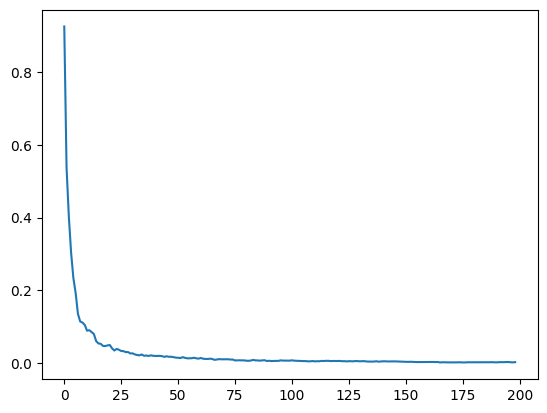

In [ ]:
plt.plot(np.arange(n - 1), reg.mean(0))
plt.savefig('offline.png')

In [ ]:
reg_on = np.empty((200, n - 1))
for i in range(200):
    #mu = np.random.rand(A)
    theta = np.random.normal(0, np.sqrt(1/d), size=d)
    mu = np.dot(phi, theta)
    X = torch.zeros((1, n + 1, A + 3), device=device)
    X[0, :, 0] = 1
    X[0, :, -2] = 1
    for j in range(n - 1):
        with torch.no_grad():
            prediction = torch.softmax(model(X)[j], 0).cpu().numpy()
        a = np.random.choice(A, p=prediction)
        reg_on[i][j] = np.max(mu) - mu[a]

        if j == n:
            break

        X[0, j + 1, a + 1] = 1
        X[0, j + 1, -1] = mu[a] #np.random.normal(mu[a], 0.3)
reg_on = reg_on.mean(0)

In [ ]:
plt.plot(np.arange(n - 1), reg.cumsum())
plt.savefig('online.png')